<a href="https://colab.research.google.com/github/WeiHao-19/weihaoi.github.io/blob/gh-pages/FISH_CONTRAL%E7%A7%BB%E6%A4%8D%E5%89%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 加载keras并查看版本
import keras
keras.__version__

'2.4.3'

In [ ]:
# 从keras中导入这次实例要用到的数据集
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [ ]:
# 训练数据集的形状，也即404组，每组数据有13维
train_data.shape

(404, 13)

在这个实例中含有 404 个 training samples 与 102 个 test samples.每个sample含有13 features.考虑到后期使用特定研究区域的鱼类资源调差数据所搭建的真实数据集，以下展示简单def以下未来可能在局部海域一个季度内所采用的feathers
1. 条件捕捞死亡率
2. 条件自然死亡率
3. 研究海域每公顷初级生产力 （每公顷叶绿素a含量）
4. 渔获年龄 (= 1 if 最小可捕捞年龄; 0 otherwise).
5. 季度补充群体 (每公顷)
6. 季度剩余群体 (每公顷)
7. 季度捕获网数
8. 季度区间内每网捕获个体平均体重 （g）
9. 季度区间内每网捕获个体平均体长 （cm）
10. 作业海区到中心渔场的绝对距离
11. 海水温度（= 1 if 捕捞鱼群最适生长温度范围； 0 otherwise）
12. 海水水文条件.
13. 饵料可食性：1000 * (FS - 0.63) ** 2 其中FS为食物supply量

In [ ]:
# 测试数据的数目、维度
test_data.shape

(102, 13)

In [ ]:
# 这次实例的标量，也即房价中位数的标签（unit：1000$）
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [ ]:
# 上一步可以看到要输入到神经网络中的数据取值范围差异很大，这是有问题。
# 网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。
# 对于这种数据，普遍采用标准化，即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差
# 这样得到的特征平均值为 0，标准差为 1。用 Numpy 可以很容易实现标准化。
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [ ]:
from keras import models
from keras import layers

def build_model():
    # 使用 function 去 construct 模型
    # 是因为预测项目需要将同一个模型多次实例化
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # 准备验证数据：第k个 partition 
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 准备训练数据： 其余所有的 partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 搭建 Keras model (已经编译过的)
    model = build_model()
    # 训练 model (静默模式, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
# 计算所有轮次中的 K 折验证分数平均值，为下一步绘制平均绝对误差（MAE，mean absolute error）
# 作准备
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

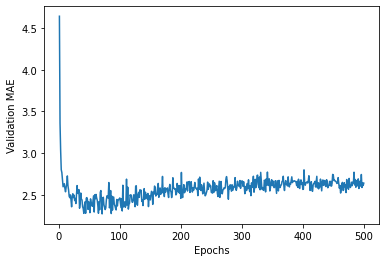

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 从结果上来看
因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。应该重新绘制一张图：
- 删除前 10 个数据点，因为它们的取值范围与曲线上的其他点不同。
- 将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

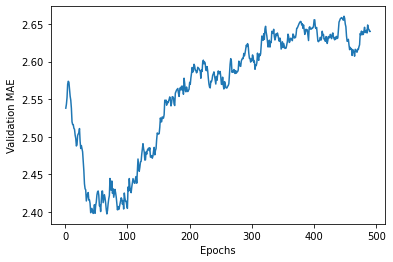

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从图中可以看出，验证 MAE 在 80 轮左右？就不再显著降低，之后就开始过拟合。

In [ ]:
# 有了上面的多轮尝试和经验，再构建一个全新的、编译好的model.
model = build_model()
# 再在所有的数据上（训练数据、训练标签）应用这个model
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 16.3268 - mae: 2.6229


In [ ]:
test_mae_score

2.622852087020874

预测的房价还是和实际价格相差约 2623 美元。
- 这是平均绝对误差（MAE，mean absolute error）的直观化表示。即预测值与目标值之差的绝对值。比如，这个实例中的test_mae_score等于 2.622852087020874，就表示最终训练得到的模型预测的房价与实际价格平均相差约 2623 美元。